<a href="https://colab.research.google.com/github/NiZhLi/ML-homework/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 作業一

In [ ]:
def get_mnist():
    # The code to download the mnist data original came from
    # https://cntk.ai/pythondocs/CNTK_103A_MNIST_DataLoader.html

    import gzip
    import numpy as np
    import os
    import struct

    from urllib.request import urlretrieve

    def load_data(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x3080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))[0]
                if n != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} entries.".format(num_samples)
                    )
                crow = struct.unpack(">I", gz.read(4))[0]
                ccol = struct.unpack(">I", gz.read(4))[0]
                if crow != 28 or ccol != 28:
                    raise Exception(
                        "Invalid file: expected 28 rows/cols per image."
                    )
                # Read data.
                res = np.frombuffer(
                    gz.read(num_samples * crow * ccol), dtype=np.uint8
                )
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples, crow, ccol)) / 256


    def load_labels(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x1080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))
                if n[0] != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} rows.".format(num_samples)
                    )
                # Read labels.
                res = np.frombuffer(gz.read(num_samples), dtype=np.uint8)
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples))


    def try_download(data_source, label_source, num_samples):
        data = load_data(data_source, num_samples)
        labels = load_labels(label_source, num_samples)
        return data, labels

    # Not sure why, but yann lecun's website does no longer support
    # simple downloader. (e.g. urlretrieve and wget fail, while curl work)
    # Since not everyone has linux, use a mirror from uni server.
    #     server = 'http://yann.lecun.com/exdb/mnist'
    server = 'https://raw.githubusercontent.com/fgnt/mnist/master'

    # URLs for the train image and label data
    url_train_image = f'{server}/train-images-idx3-ubyte.gz'
    url_train_labels = f'{server}/train-labels-idx1-ubyte.gz'
    num_train_samples = 60000

    print("Downloading train data")
    train_features, train_labels = try_download(url_train_image, url_train_labels, num_train_samples)

    # URLs for the test image and label data
    url_test_image = f'{server}/t10k-images-idx3-ubyte.gz'
    url_test_labels = f'{server}/t10k-labels-idx1-ubyte.gz'
    num_test_samples = 10000

    print("Downloading test data")
    test_features, test_labels = try_download(url_test_image, url_test_labels, num_test_samples)

    return train_features, train_labels, test_features, test_labels


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))  # 範圍 [0,1]

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# 損失函數：重建誤差 + KL divergence
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
def train_vae(train_features, test_features, epochs=10, batch_size=128, lr=1e-3):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 建立 Dataset / DataLoader
    train_data = torch.tensor(train_features, dtype=torch.float32).view(-1, 784)
    test_data = torch.tensor(test_features, dtype=torch.float32).view(-1, 784)
    train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)

    # 初始化模型
    model = VAE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 訓練迴圈
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(x)
            loss = vae_loss(recon, x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        avg_loss = train_loss / len(train_loader.dataset)
        print(f"Epoch {epoch}, Avg Loss: {avg_loss:.4f}")

    # 測試並顯示重建效果
    model.eval()
    with torch.no_grad():
        test_batch = test_data[:8].to(device)
        recon_batch, _, _ = model(test_batch)

    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i in range(8):
        axes[0, i].imshow(test_batch[i].cpu().view(28, 28), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(recon_batch[i].cpu().view(28, 28), cmap="gray")
        axes[1, i].axis("off")
    plt.show()


Done.
Done.
Done.
Done.
Epoch 1, Avg Loss: 165.4803
Epoch 2, Avg Loss: 122.5858
Epoch 3, Avg Loss: 115.3563
Epoch 4, Avg Loss: 112.2845
Epoch 5, Avg Loss: 110.5022
Epoch 6, Avg Loss: 109.3759
Epoch 7, Avg Loss: 108.4941
Epoch 8, Avg Loss: 107.8451
Epoch 9, Avg Loss: 107.3995
Epoch 10, Avg Loss: 106.9695


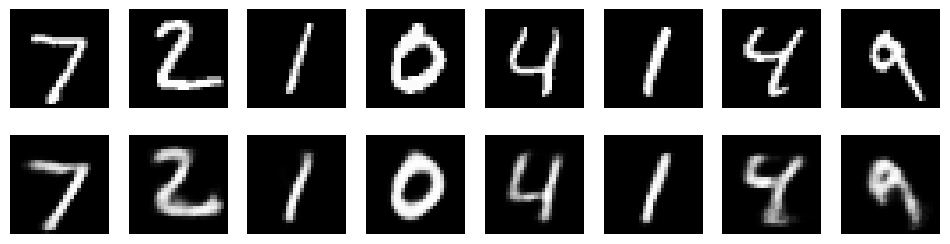

In [ ]:
train_features, train_labels, test_features, test_labels = get_mnist()
train_vae(train_features, test_features, epochs=10)

# 作業二

## VAE

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.24MB/s]


Epoch [1/30] Loss: 165.6817
Epoch [2/30] Loss: 121.8054
Epoch [3/30] Loss: 114.8626
Epoch [4/30] Loss: 111.9616
Epoch [5/30] Loss: 110.1205
Epoch [6/30] Loss: 108.9645
Epoch [7/30] Loss: 108.1110
Epoch [8/30] Loss: 107.4610
Epoch [9/30] Loss: 106.8871
Epoch [10/30] Loss: 106.4715
Epoch [11/30] Loss: 106.1059
Epoch [12/30] Loss: 105.7801
Epoch [13/30] Loss: 105.5475
Epoch [14/30] Loss: 105.2672
Epoch [15/30] Loss: 105.0512
Epoch [16/30] Loss: 104.8593
Epoch [17/30] Loss: 104.6260
Epoch [18/30] Loss: 104.4972
Epoch [19/30] Loss: 104.3295
Epoch [20/30] Loss: 104.2407
Epoch [21/30] Loss: 104.0871
Epoch [22/30] Loss: 103.9238
Epoch [23/30] Loss: 103.7849
Epoch [24/30] Loss: 103.7048
Epoch [25/30] Loss: 103.5804
Epoch [26/30] Loss: 103.4759
Epoch [27/30] Loss: 103.4056
Epoch [28/30] Loss: 103.2898
Epoch [29/30] Loss: 103.1843
Epoch [30/30] Loss: 103.1419


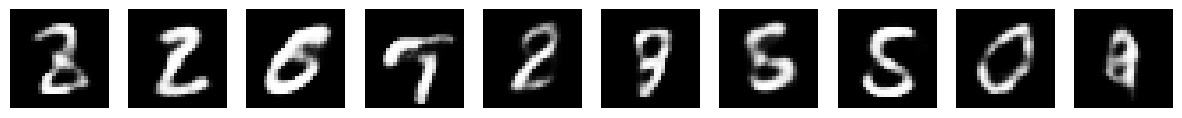

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# 固定隨機種子
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# ========== Dataset ==========
transform = transforms.Compose([
    transforms.ToTensor(),  # 轉為 tensor (0~1)
])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# ========== VAE Model ==========
class VAE(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# ========== Loss Function ==========
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    # KLD = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 30
model.train()
for epoch in range(1, epochs + 1):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28*28).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch [{epoch}/{epochs}] Loss: {train_loss / len(train_loader.dataset):.4f}")

# ========== 生成影像 ==========
model.eval()
with torch.no_grad():
    z = torch.randn(10, 20).to(device)  # 從標準正態分布取樣
    samples = model.decode(z).cpu().view(-1, 1, 28, 28)

# 畫出 10 張隨機影像
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(samples[i].squeeze(), cmap="gray")
    axes[i].axis("off")
plt.show()


## GAN

Epoch [1/30]  Loss D: 0.3273, Loss G: 1.4967
Epoch [2/30]  Loss D: 0.5485, Loss G: 3.1309
Epoch [3/30]  Loss D: 0.6237, Loss G: 5.4888
Epoch [4/30]  Loss D: 0.3461, Loss G: 4.0478
Epoch [5/30]  Loss D: 0.6434, Loss G: 0.4086
Epoch [6/30]  Loss D: 0.2127, Loss G: 2.0082
Epoch [7/30]  Loss D: 0.3308, Loss G: 3.6673
Epoch [8/30]  Loss D: 0.2963, Loss G: 1.9299
Epoch [9/30]  Loss D: 0.1841, Loss G: 2.9166
Epoch [10/30]  Loss D: 0.2170, Loss G: 2.0011
Epoch [11/30]  Loss D: 0.2657, Loss G: 2.2948
Epoch [12/30]  Loss D: 0.2003, Loss G: 2.2353
Epoch [13/30]  Loss D: 0.5317, Loss G: 4.5382
Epoch [14/30]  Loss D: 0.3111, Loss G: 1.7656
Epoch [15/30]  Loss D: 0.4015, Loss G: 2.2370
Epoch [16/30]  Loss D: 0.3385, Loss G: 1.7224
Epoch [17/30]  Loss D: 0.3833, Loss G: 1.3480
Epoch [18/30]  Loss D: 0.4228, Loss G: 1.4350
Epoch [19/30]  Loss D: 0.4753, Loss G: 1.8591
Epoch [20/30]  Loss D: 0.4170, Loss G: 1.7245
Epoch [21/30]  Loss D: 0.5025, Loss G: 0.8342
Epoch [22/30]  Loss D: 0.4527, Loss G: 1.38

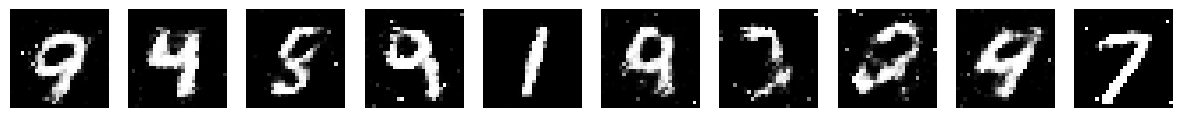

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# 固定隨機種子
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# ========== Dataset ==========
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # 將 MNIST 正規化到 [-1, 1]
])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# ========== Generator ==========
class Generator(nn.Module):
    def __init__(self, z_dim=100, hidden_dim=256, img_dim=28*28):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*2, img_dim),
            nn.Tanh()  # 輸出範圍 [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

# ========== Discriminator ==========
class Discriminator(nn.Module):
    def __init__(self, img_dim=28*28, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # 輸出真假機率
        )

    def forward(self, x):
        return self.model(x)

# ========== 初始化 ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 100
generator = Generator(z_dim=z_dim).to(device)
discriminator = Discriminator().to(device)

# Loss & Optimizer
criterion = nn.BCELoss()
lr = 2e-4
opt_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# ========== Training ==========
epochs = 30
for epoch in range(1, epochs+1):
    for real, _ in train_loader:
        real = real.view(-1, 28*28).to(device)
        batch_size = real.size(0)

        ### 訓練判別器 ###
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = generator(noise)

        disc_real = discriminator(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))  # 真圖 label=1

        disc_fake = discriminator(fake.detach()).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))  # 假圖 label=0

        lossD = (lossD_real + lossD_fake) / 2

        opt_disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        ### 訓練生成器 ###
        output = discriminator(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))  # 生成器希望騙過 D → label=1

        opt_gen.zero_grad()
        lossG.backward()
        opt_gen.step()

    print(f"Epoch [{epoch}/{epochs}]  Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")

# ========== 生成影像 ==========
generator.eval()
with torch.no_grad():
    z = torch.randn(10, z_dim).to(device)
    samples = generator(z).cpu().view(-1, 1, 28, 28)

# 顯示 10 張隨機影像
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(samples[i].squeeze()*0.5+0.5, cmap="gray")  # 轉回 [0,1]
    axes[i].axis("off")
plt.show()


## cGAN

Epoch [1/30] Loss D: 0.3098, Loss G: 2.8375
Epoch [2/30] Loss D: 0.2903, Loss G: 2.2413
Epoch [3/30] Loss D: 0.3106, Loss G: 3.3844
Epoch [4/30] Loss D: 0.2636, Loss G: 3.1954
Epoch [5/30] Loss D: 0.5817, Loss G: 7.3992
Epoch [6/30] Loss D: 0.3000, Loss G: 1.9382
Epoch [7/30] Loss D: 0.3375, Loss G: 3.5798
Epoch [8/30] Loss D: 0.2436, Loss G: 3.3848
Epoch [9/30] Loss D: 0.2826, Loss G: 4.0361
Epoch [10/30] Loss D: 0.3890, Loss G: 1.5149
Epoch [11/30] Loss D: 0.3202, Loss G: 3.1729
Epoch [12/30] Loss D: 0.4138, Loss G: 1.4792
Epoch [13/30] Loss D: 0.3958, Loss G: 1.6504
Epoch [14/30] Loss D: 0.4331, Loss G: 2.7381
Epoch [15/30] Loss D: 0.4246, Loss G: 1.5212
Epoch [16/30] Loss D: 0.4205, Loss G: 2.6423
Epoch [17/30] Loss D: 0.4187, Loss G: 1.9681
Epoch [18/30] Loss D: 0.4963, Loss G: 2.1031
Epoch [19/30] Loss D: 0.4500, Loss G: 1.8180
Epoch [20/30] Loss D: 0.4813, Loss G: 1.2414
Epoch [21/30] Loss D: 0.5017, Loss G: 1.8820
Epoch [22/30] Loss D: 0.5302, Loss G: 1.6154
Epoch [23/30] Loss 

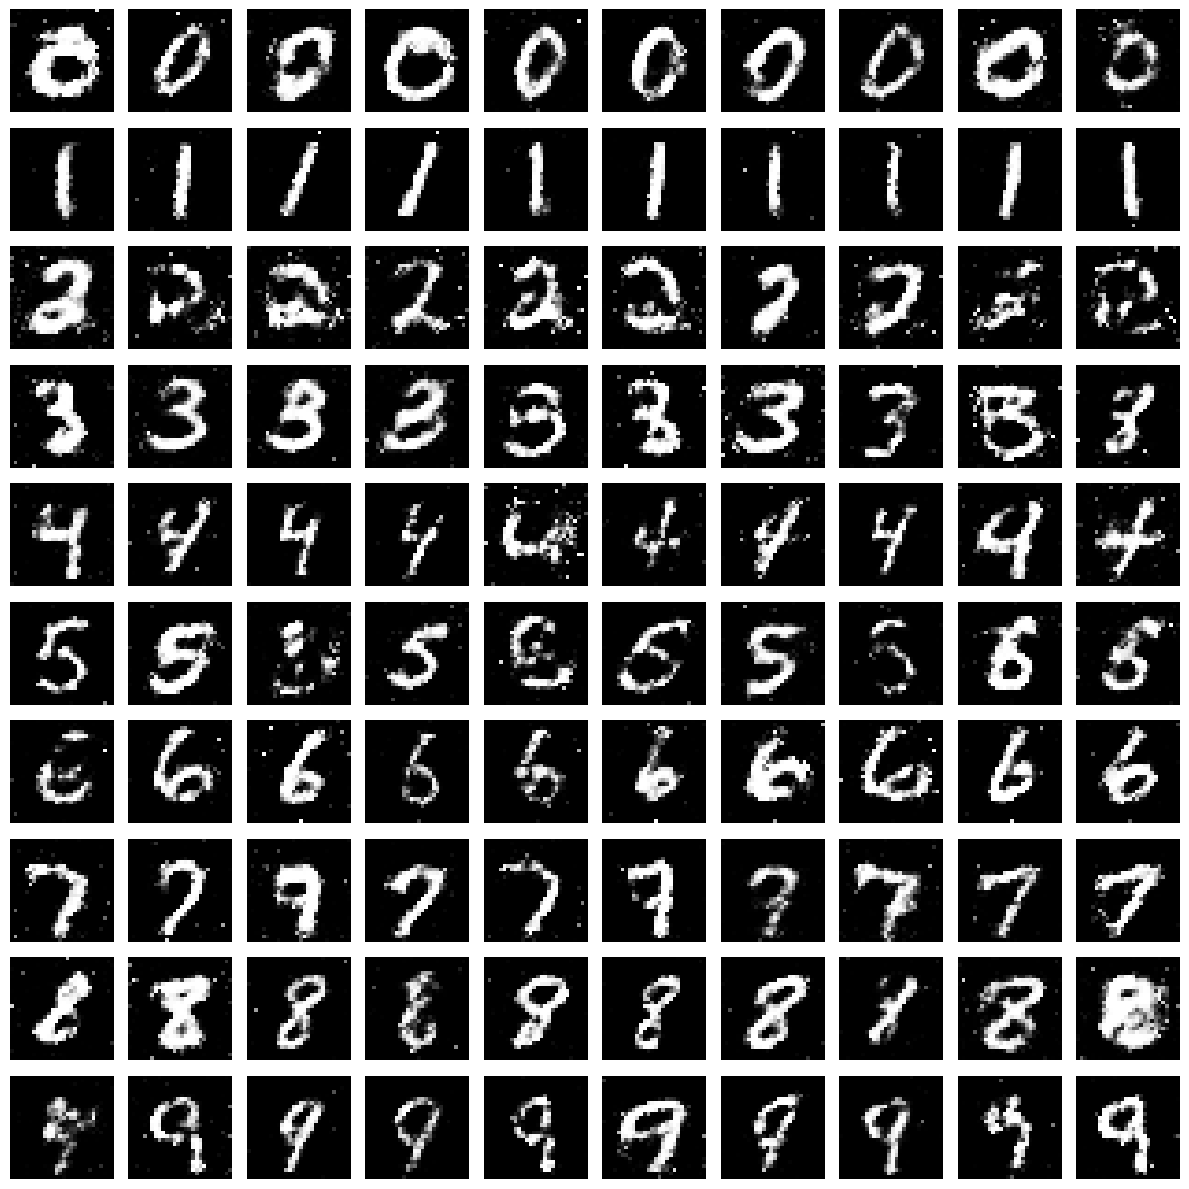

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# 固定隨機種子
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# ========== Dataset ==========
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # [-1, 1]
])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# ========== cGAN 模型 ==========
class Generator(nn.Module):
    def __init__(self, z_dim=100, num_classes=10, img_dim=28*28, hidden_dim=256):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim + num_classes, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*2, img_dim),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # labels: one-hot
        x = torch.cat([z, labels], dim=1)
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, num_classes=10, img_dim=28*28, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim + num_classes, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        x = torch.cat([img, labels], dim=1)
        return self.model(x)

# One-hot 編碼
def one_hot(labels, num_classes=10):
    return torch.eye(num_classes)[labels]

# ========== 初始化 ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 100
generator = Generator(z_dim=z_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
lr = 2e-4
opt_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# ========== Training ==========
epochs = 30
for epoch in range(1, epochs+1):
    for real, labels in train_loader:
        real = real.view(-1, 28*28).to(device)
        labels = one_hot(labels).to(device)
        batch_size = real.size(0)

        ### 訓練 Discriminator ###
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = generator(noise, labels)

        disc_real = discriminator(real, labels).view(-1)
        # label smoothing: 真樣本的 target 從 1.0 改為 0.9
        lossD_real = criterion(disc_real, torch.ones_like(disc_real) * 0.9)

        disc_fake = discriminator(fake.detach(), labels).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        lossD = (lossD_real + lossD_fake) / 2

        opt_disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        ### 訓練 Generator ###
        output = discriminator(fake, labels).view(-1)
        lossG = criterion(output, torch.ones_like(output))  # 生成器希望判斷為真

        opt_gen.zero_grad()
        lossG.backward()
        opt_gen.step()

    print(f"Epoch [{epoch}/{epochs}] Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")

# ========== 生成 0–9 各 10 張影像 ==========
generator.eval()
num_classes = 10
n_samples_per_class = 10
with torch.no_grad():
    z = torch.randn(num_classes * n_samples_per_class, z_dim).to(device)
    labels = torch.arange(num_classes).repeat_interleave(n_samples_per_class)
    labels = one_hot(labels, num_classes=num_classes).to(device)

    samples = generator(z, labels).cpu().view(-1, 1, 28, 28)

# ========== 畫 10×10 圖格 ==========
fig, axes = plt.subplots(num_classes, n_samples_per_class, figsize=(12, 12))
idx = 0
for i in range(num_classes):
    for j in range(n_samples_per_class):
        axes[i, j].imshow(samples[idx].squeeze()*0.5+0.5, cmap="gray")  # 轉回 [0,1]
        axes[i, j].axis("off")
        idx += 1
plt.tight_layout()
plt.show()


## Diffusion

In [ ]:
!pip install torchinfo

In [ ]:
import torch

print("GPU name:", torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

GPU name: Tesla T4 

Device is: cuda 

Total number of GPUs: 1


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

from torchvision.utils import make_grid
from tqdm import tqdm
from torchinfo import summary


# ========== (reference:randomaccess2023)this model will be delete after the course is done ============


transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)


training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

class Linear_Variance_Scheduler:
    def __init__(self, time_steps, beta_start, beta_end, device='cuda'):

        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

    def diffusion_process(self, x, noise, t):
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]

get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)

class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()

        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))

    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()

        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)

    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()

        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )

        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))

    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()

        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )

        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))

    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

class UNet(nn.Module):
    def __init__(self, t_emb_dim, device='cuda'):
        super(UNet, self).__init__()

        self.device = device
        self.t_emb_dim = t_emb_dim

        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)

        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)

        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)

        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb

    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)

        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output


ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02)
model = UNet(t_emb_dim=256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)

n_epochs = 20
training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []

    for data, _ in tqdm(training_dataloader):
        model.train()
        data = data.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model(xt, t)
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()

    with torch.inference_mode():
        for data, _ in tqdm(test_dataloader):
            model.eval()
            data = data.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt, t)
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses.append(tst_batch_loss.item())
        test_per_epoch_loss = np.array(test_losses).mean()

    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)

    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')




100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 346kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.1MB/s]
100%|██████████| 156/156 [00:15<00:00,  9.93it/s]


Epoch: 1/20	| Training loss: 0.0583 |   Test loss: 0.0298


100%|██████████| 156/156 [00:15<00:00,  9.87it/s]


Epoch: 2/20	| Training loss: 0.0277 |   Test loss: 0.0243


100%|██████████| 156/156 [00:16<00:00,  9.65it/s]


Epoch: 3/20	| Training loss: 0.0237 |   Test loss: 0.0216


100%|██████████| 156/156 [00:15<00:00,  9.84it/s]


Epoch: 4/20	| Training loss: 0.0213 |   Test loss: 0.0214


100%|██████████| 156/156 [00:16<00:00,  9.61it/s]


Epoch: 5/20	| Training loss: 0.0203 |   Test loss: 0.0187


100%|██████████| 156/156 [00:15<00:00,  9.76it/s]


Epoch: 6/20	| Training loss: 0.0192 |   Test loss: 0.0194


100%|██████████| 156/156 [00:16<00:00,  9.66it/s]


Epoch: 7/20	| Training loss: 0.0186 |   Test loss: 0.0180


100%|██████████| 156/156 [00:15<00:00,  9.81it/s]


Epoch: 8/20	| Training loss: 0.0182 |   Test loss: 0.0171


100%|██████████| 156/156 [00:15<00:00,  9.77it/s]


Epoch: 9/20	| Training loss: 0.0177 |   Test loss: 0.0170


100%|██████████| 156/156 [00:15<00:00,  9.82it/s]


Epoch: 10/20	| Training loss: 0.0174 |   Test loss: 0.0174


100%|██████████| 156/156 [00:15<00:00,  9.79it/s]


Epoch: 11/20	| Training loss: 0.0171 |   Test loss: 0.0178


100%|██████████| 156/156 [00:15<00:00,  9.83it/s]


Epoch: 12/20	| Training loss: 0.0168 |   Test loss: 0.0163


100%|██████████| 156/156 [00:15<00:00,  9.77it/s]


Epoch: 13/20	| Training loss: 0.0170 |   Test loss: 0.0165


 12%|█▏        | 110/937 [00:28<03:37,  3.79it/s]

In [ ]:
gen_imgs, _ = ddpm.ddpm_sampling(model, num_samples=10, channels=1, img_size=32)
gen_imgs = gen_imgs[:, :, 2:30, 2:30]

# 顯示
fig, axes = plt.subplots(1, 10, figsize=(15,2))
for i in range(10):
    axes[i].imshow(gen_imgs[i].squeeze().cpu().numpy(), cmap="gray")
    axes[i].axis("off")
plt.show()

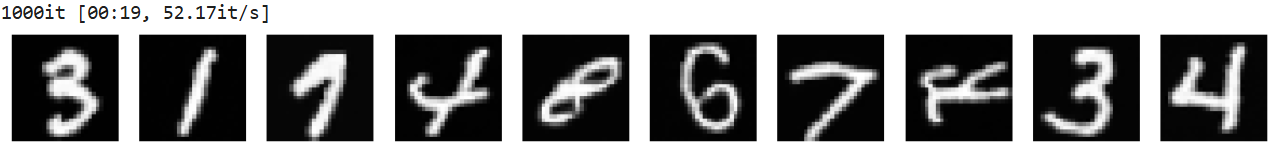
用其他帳號的colab跑出來的結果